## Identifying a Proteomic Signature of Severe COVID-19
### Model Development
#### C.V. Cosgriff, MD, MPH

### 1- Environment

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

# file utilities
from os import path
import pickle

import matplotlib.pyplot as plt
from matplotlib.patches import Patch # for custom legends
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline
%config InlineBackend.figure_format='retina'

### 2- Data

In [2]:
df = pd.read_csv('../data/MESSI-COVID-Proteomics_final-dat_processed.csv')

### 3- Analysis Functions

In [3]:
def bh_fdr(df, Q=0.05):
    df = df.sort_values('p_value')
    i = np.array([i for i in range(df.shape[0])])+1
    m = np.float64(df.shape[0])
    bh_cv = (i/m)*Q
    df = df.assign(bh_cv=bh_cv)
    compare_cv = df.p_value < df.bh_cv
    df = df.assign(compare_cv=compare_cv)
    df = df.loc[df.compare_cv, :]
    return df.p_value.max()

def enrich(df, y, x_f, x_l, L=[], Q=None, metadata_file=None):
    npx = df.loc[:, x_f:x_l]
    npx = npx.assign(y=df.loc[:, y]).rename({'y' : f'{y}'}, axis=1)
    npx = npx.groupby(y).mean().T.reset_index().rename({'index' : 'uniprot'}, axis=1)
    npx = npx.rename({True : y + '_1', False : y + '_0'}, axis=1)
    npx_difference = npx.loc[:, y + '_1'] - npx.loc[:, y + '_0']
    npx = npx.assign(npx_difference=npx_difference)
    
    results = {}
    y_col = y
    subset = L.copy()
    subset.append(y_col)
    subset.append('start')
    
    for i in df.loc[:, x_f:x_l].columns:
        subset.pop()
        subset.append(i)
        temp = df.loc[:, subset]
        temp = temp.dropna()
        X = temp.drop(f'{y_col}', axis=1)
        X = sm.add_constant(X)
        y = temp.loc[:, f'{y_col}']
        logit_mdl = sm.Logit(y, X).fit(disp=0)
        p = logit_mdl.pvalues[i]
        OR = np.exp(logit_mdl.params[i])
        results[i] = np.array([p, OR]).flatten()
    
    results = pd.DataFrame(results).T.rename({0 : 'p_value', 1 : 'OR'}, axis=1)
    results = results.reset_index().rename({'index' : 'uniprot'}, axis=1)
    results = results.loc[:, ['uniprot', 'OR', 'p_value']]
    minuslog10p = (-1)*np.log10(results.p_value)
    results = results.assign(minuslog10p=minuslog10p)
    
    npx = npx.merge(results, how='left', on='uniprot')
    
    if (Q != None):
        fdr = bh_fdr(npx, Q)
        below_fdr = npx.p_value < fdr
        npx = npx.assign(below_fdr=below_fdr)
    
    if (metadata_file != None):
        metadata = pd.read_csv(metadata_file).loc[:, ['uniprot', 'gene_name', 'gene_description']]
        metadata = metadata.drop_duplicates(subset='uniprot', keep='first')
        npx = npx.merge(metadata, how='left', on='uniprot')
    
    return npx.sort_values('p_value').reset_index(drop=True)

def plot_volcano_labeled(npx, title=None, annotate_cutoff=0, annotate_gene=True, figsize=(10,10)):
    plt.figure(figsize=figsize)

    features = ['TNC', 'CCL7', 'IL1RL1', 'MMP7', 'TGFA', 'IL17C', 'CD274', 
                'LGALS9', 'SPP1', 'IL12B', 'TNFSF11', 'APOM', 'MMP9', 'LTA']

    sig_colors = ['#e41a1c', '#377eb8']

    def csigmap(npx_diff, below_fdr):
        if below_fdr:
            if npx_diff <= 0:
                return '#1560bd'
            else:
                return '#e41a1c'
        else:
            return 'gray'

    sig_map = {True : '#1560bd', False : 'gray'}

    color = [csigmap(i, j) for i, j in zip(npx.npx_difference, npx.below_fdr)]


    plt.scatter(x=npx.npx_difference, y=npx.minuslog10p, color=color, s=6)
    plt.xlabel('NPX Difference')
    plt.ylabel('$-log_{10}(p)$')
    
    fdr_line = np.min(npx.loc[npx.below_fdr == True, 'minuslog10p'])
    plt.axhline(y=fdr_line, color='black', linestyle='--', lw=1)
    # plt.axvline(x=1, color='black', linestyle='--')
    
    # label_df = npx.loc[(np.abs(npx.npx_difference) >= annotate_cutoff) & (npx.below_fdr), :]
    label_df = npx.loc[npx.gene_name.isin(features), :]

    # add offset column to the label DataFrame
    label_df.loc[:, 'offset_x'] = 0
    label_df.loc[:, 'offset_y'] = 0

    # manual map offset labeling proteins from final model

    ## TNFSF11
    label_df.loc[label_df.gene_name == 'TNFSF11', 'offset_x'] = -0.10
    label_df.loc[label_df.gene_name == 'TNFSF11', 'offset_y'] = 0.10

    ## APOM
    label_df.loc[label_df.gene_name == 'APOM', 'offset_x'] = 0.05
    label_df.loc[label_df.gene_name == 'APOM', 'offset_y'] = 0.10

    ## LTA
    label_df.loc[label_df.gene_name == 'LTA', 'offset_x'] = -0.10
    label_df.loc[label_df.gene_name == 'LTA', 'offset_y'] = 0.05

    ## LGALS9
    label_df.loc[label_df.gene_name == 'LGALS9', 'offset_x'] = -0.20
    label_df.loc[label_df.gene_name == 'LGALS9', 'offset_y'] = 0.10

    ## IL12B
    label_df.loc[label_df.gene_name == 'IL12B', 'offset_x'] = -0.10
    label_df.loc[label_df.gene_name == 'IL12B', 'offset_y'] = 0.10

    ## MMP7
    label_df.loc[label_df.gene_name == 'MMP7', 'offset_x'] = -0.10
    label_df.loc[label_df.gene_name == 'MMP7', 'offset_y'] = 0.25

    ## TGFA
    label_df.loc[label_df.gene_name == 'TGFA', 'offset_x'] = -0.10
    label_df.loc[label_df.gene_name == 'TGFA', 'offset_y'] = -0.25

    ## CD274
    label_df.loc[label_df.gene_name == 'CD274', 'offset_x'] = 0.05
    label_df.loc[label_df.gene_name == 'CD274', 'offset_y'] = 0

    ## IL17C
    label_df.loc[label_df.gene_name == 'IL17C', 'offset_x'] = -0.1
    label_df.loc[label_df.gene_name == 'IL17C', 'offset_y'] = -0.25

    ## MMP9
    label_df.loc[label_df.gene_name == 'MMP9', 'offset_x'] = 0.025
    label_df.loc[label_df.gene_name == 'MMP9', 'offset_y'] = -0.05

    ## SPP1
    label_df.loc[label_df.gene_name == 'SPP1', 'offset_x'] = -.1
    label_df.loc[label_df.gene_name == 'SPP1', 'offset_y'] = 0

    ## TNC
    label_df.loc[label_df.gene_name == 'TNC', 'offset_x'] = -.1
    label_df.loc[label_df.gene_name == 'TNC', 'offset_y'] = 0

    ## CCL7
    label_df.loc[label_df.gene_name == 'CCL7', 'offset_x'] = -.1
    label_df.loc[label_df.gene_name == 'CCL7', 'offset_y'] = 0

    ## IL1RL1
    label_df.loc[label_df.gene_name == 'IL1RL1', 'offset_x'] = -.05
    label_df.loc[label_df.gene_name == 'IL1RL1', 'offset_y'] = -.25
    
    if (annotate_gene):
        for i in label_df.gene_name:
            x = label_df.loc[label_df.gene_name == i, 'npx_difference']
            y = label_df.loc[label_df.gene_name == i, 'minuslog10p']
            if ((x <= 0).any()):
                plt.annotate(i, (x, y), fontsize=12, 
                xytext=(x+label_df.loc[label_df.gene_name == i, 'offset_x'], 
                        y+label_df.loc[label_df.gene_name == i, 'offset_y']),
                arrowprops = dict(arrowstyle='-', color='#1560bd'))
            else:
                plt.annotate(i, (x, y), fontsize=12, 
                xytext=(x+label_df.loc[label_df.gene_name == i, 'offset_x'], 
                        y+label_df.loc[label_df.gene_name == i, 'offset_y']), 
                arrowprops = dict(arrowstyle='-', color='#e41a1c'))
    else:
        for i in label_df.uniprot:
            x = label_df.loc[label_df.uniprot == i, 'npx_difference']
            y = label_df.loc[label_df.uniprot == i, 'minuslog10p']
            plt.annotate(i, (x, y), fontsize=12)
    plt.show()

### 4- Regression Analysis

,uniprot,mod_sev_d0_0,mod_sev_d0_1,npx_difference,OR,p_value,minuslog10p,below_fdr,gene_name,gene_description
0,P80511,3.953606,5.462074,1.508468,2.878350,1.900057e-08,7.721233,True,S100A12,S100 calcium binding protein A12
1,Q01638,5.797094,7.405824,1.608730,3.094588,2.091477e-08,7.679547,True,IL1RL1,interleukin 1 receptor-like 1
2,P14210,10.643207,11.800710,1.157503,2.603138,1.926723e-07,6.715181,True,HGF,hepatocyte growth factor (hepapoietin A; scatt...
3,Q9Y279,6.552111,7.687869,1.135758,2.963671,2.114123e-07,6.674870,True,VSIG4,V-set and immunoglobulin domain containing 4
4,Q8WTT0,2.708801,1.695626,-1.013175,0.252850,2.186449e-07,6.660261,True,CLEC4C,"C-type lectin domain family 4, member C"
5,P24821,2.996374,4.093641,1.097266,3.110419,3.740469e-07,6.427074,True,TNC,tenascin C
6,P55773,11.587869,12.299172,0.711304,4.045427,7.964166e-07,6.098860,True,CCL23,chemokine (C-C motif) ligand 23
7,P01258,7.542010,9.197639,1.655629,1.825811,9.746043e-07,6.011172,True,CALCA,calcitonin-related polypeptide alpha
8,P29017,4.097932,3.453106,-0.644826,0.165795,1.045919e-06,5.980502,True,CD1C,CD1c molecule
9,P13611,4.597141,5.365661,0.768521,4.248481,1.375051e-06,5.861681,True,VCAN,versican


/Users/cvc/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/cvc/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


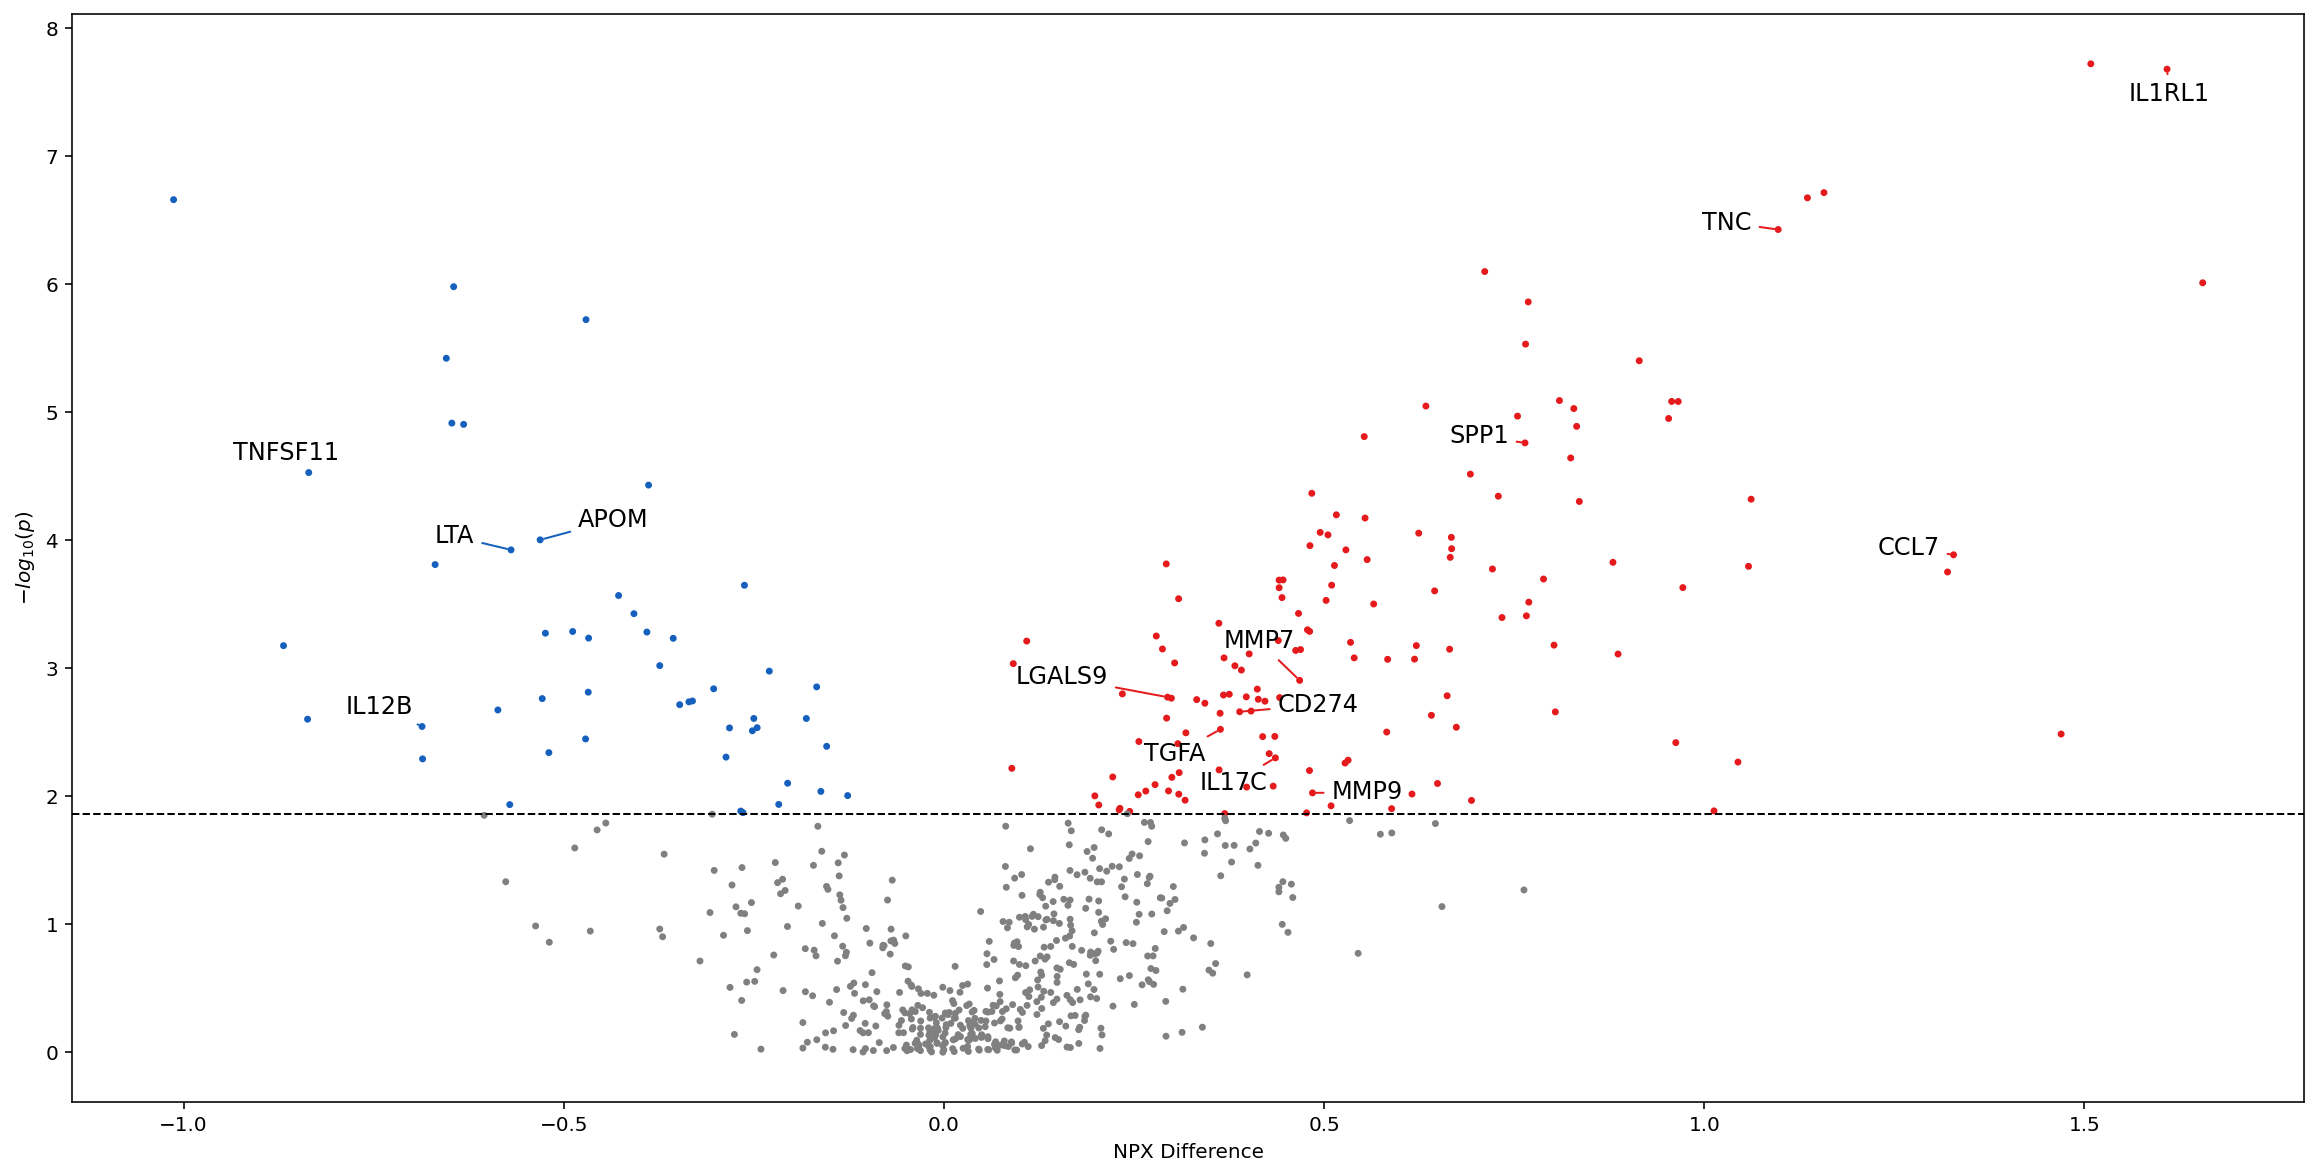

In [4]:
# calculate enrichment
results_severity_d0 = enrich(df=df, y='mod_sev_d0', x_f='O00533', x_l='Q9Y653',
                                 L=['age', 'male_sex', 'race_BAA','covid19_sx_start',
                                    'mhhtn', 'mhdm', 'mhcri'],
                                 Q=0.05, metadata_file='../data/OLink_metadata.csv')

# top hits
display(results_severity_d0[0:20])

# plot results
# plot_volcano_smalltext(results_severity_d0, annotate_cutoff=0.75, figsize=(9,6), save_fig='../figures/Figure1A.tif')
plot_volcano_labeled(results_severity_d0, annotate_cutoff=0.5, figsize=(20,10))

Output regression results for analysis in Ingenuity.

In [5]:
results_severity_d0.to_csv('../data/severity_enrichment0.csv', index=False)

### IPA Results

In [6]:
# load into DataFrame
ipa_results_noNPX = pd.read_excel('../data/ipa_results/severity_FDR05.xls')

# extract and relabel header
new_header = ipa_results_noNPX.iloc[0]
ipa_results_noNPX = ipa_results_noNPX[1:]
ipa_results_noNPX.columns = new_header
ipa_results_noNPX.columns = ['pathway', 'minuslogp', 'ratio', 'z_score', 'molecules']

# extract -logP so p-values can be extracted
ipa_results_noNPX.minuslogp = ipa_results_noNPX.minuslogp.astype('float')
p_value = np.exp(-1*ipa_results_noNPX.iloc[:, 1])
ipa_results_noNPX = ipa_results_noNPX.assign(p_value=p_value)

# visualize pathways that are significant and which have a regulation pattern
with pd.option_context('display.max_rows', None, 'display.max_columns', 25):
    display(ipa_results_noNPX.loc[(ipa_results_noNPX.p_value < 0.05) & (~pd.isna(ipa_results_noNPX.z_score)), :])

,pathway,minuslogp,ratio,z_score,molecules,p_value
2,Wound Healing Signaling Pathway,12.60,0.0754,2.065,"CALCA,CXCL8,IL12B,IL17C,IL1R2,IL1RL1,IL6,LIF,L...",0.000003
3,Tumor Microenvironment Pathway,11.80,0.0894,3,"CD274,CSF1,CXCL8,FAS,FGF23,HGF,IL6,LGALS9,MMP1...",0.000008
7,LXR/RXR Activation,9.41,0.0976,-2.887,"AMBP,APOM,CCL7,IL1R2,IL1RL1,IL6,LDLR,MMP9,SAA4...",0.000082
9,HMGB1 Signaling,8.92,0.0778,2.111,"CXCL8,IL12B,IL17C,IL6,LIF,LTA,OSM,PLAT,TNFRSF1...",0.000134
12,IL-17 Signaling,8.33,0.0695,0.277,"CCL20,CXCL8,IL12B,IL17C,IL6,LIF,LTA,MMP9,OSM,T...",0.000241
13,Crosstalk between Dendritic Cells and Natural ...,7.24,0.0989,1,"CD40,FAS,IL12B,IL6,LTA,LTBR,NECTIN2,TNFRSF1B,T...",0.000717
14,Death Receptor Signaling,7.04,0.0938,1.414,"BIRC2,DFFA,FAS,HTRA2,TNFRSF10A,TNFRSF10B,TNFRS...",0.000876
15,Cardiac Hypertrophy Signaling (Enhanced),6.96,0.035,3,"APEX1,CXCL8,FGF23,IL12B,IL17C,IL18R1,IL1R2,IL1...",0.000949
16,Erythropoietin Signaling Pathway,6.63,0.0621,0.302,"BIRC2,CXCL8,IL12B,IL17C,IL6,LIF,LTA,NOS3,OSM,T...",0.001320
18,Regulation Of The Epithelial Mesenchymal Trans...,6.28,0.0573,1.265,"CDH2,FGF23,HGF,IL6,LTA,MMP9,TNFRSF11B,TNFRSF1A...",0.001873


Cluster top pathway features.

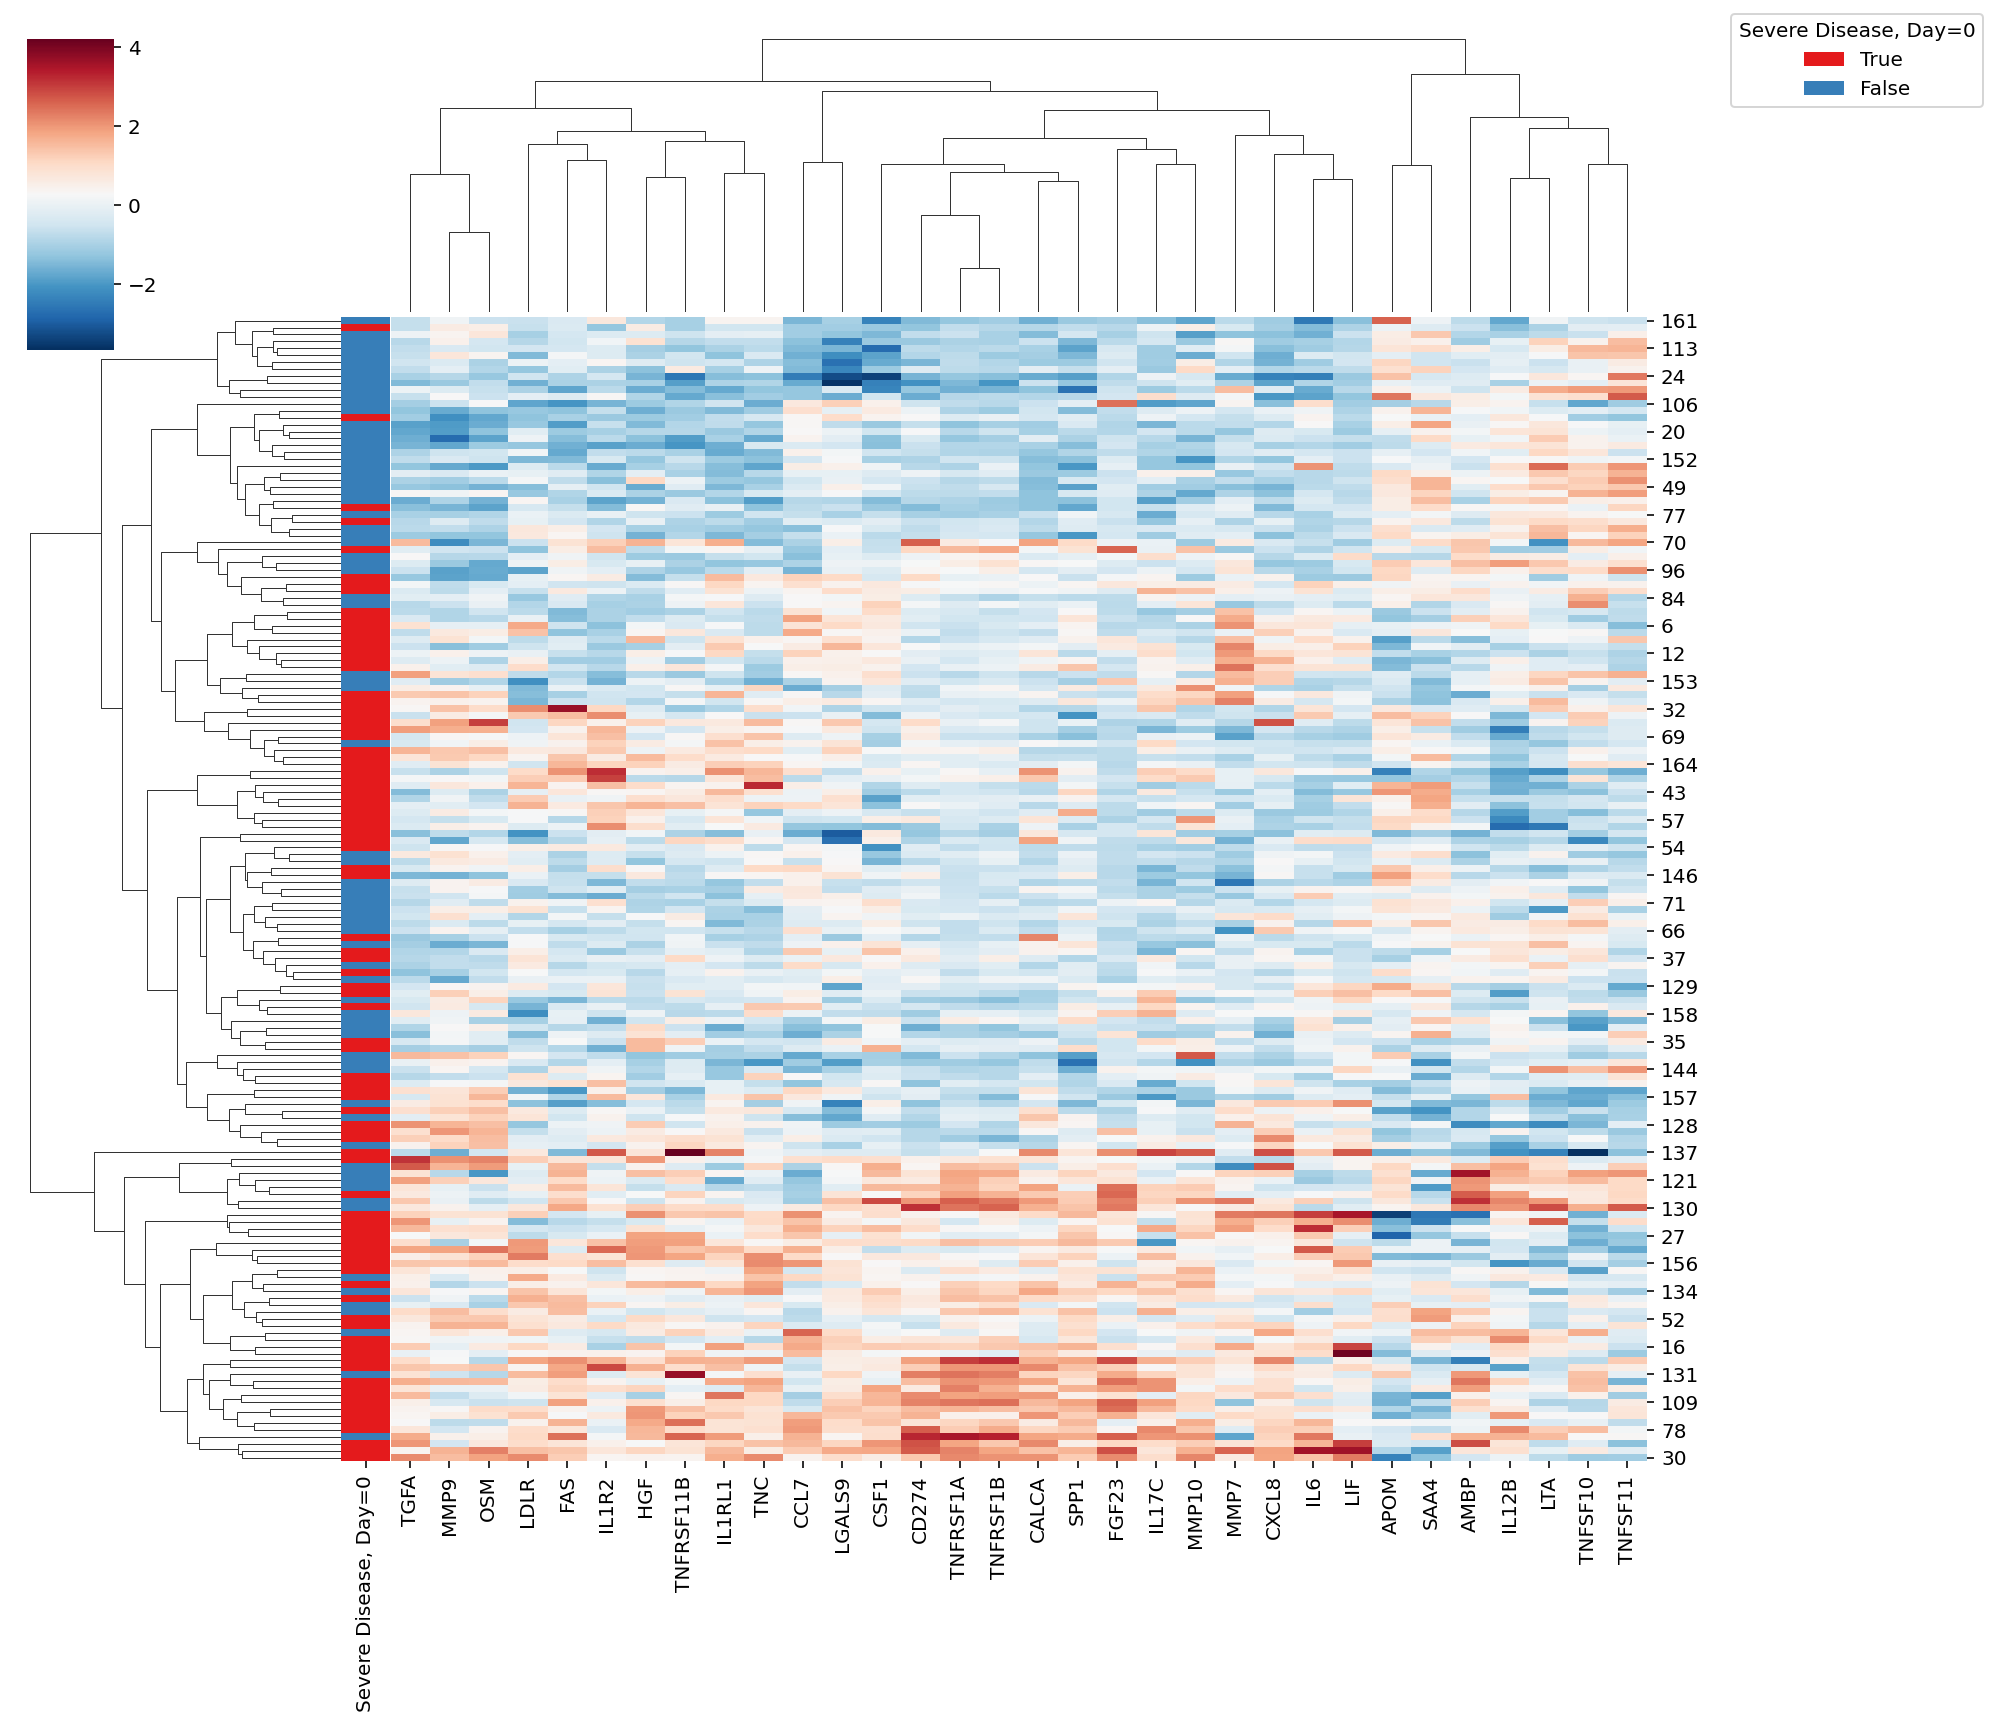

In [7]:
metadata = pd.read_csv('../data/OLink_metadata.csv')
metadata = metadata.loc[:, ['uniprot', 'gene_description', 'gene_name']]
metadata = metadata.drop_duplicates(subset='uniprot', keep='first')
uniprot_gene_map = {k:v for k, v in zip (metadata.uniprot, metadata.gene_name)}

df_uniprot = df.copy()
df_gene = df.rename(uniprot_gene_map, axis=1).rename({'IL8':'CXCL8'}, axis=1)
df = df_gene.copy()

all_features = list(df.loc[:, 'CHL1':'GPR56'].columns.values)

# because we are using multiple sources of data we are infrequently running into an issue where gene/protein names
# do not match up. The main problem play has been IL8 -> CXCL8; our metadata from Olink uses IL8 but our IPA
# results use CXCL8 and so its easier to stick with a column name of CXCL8. However, our results_sev DataFrame
# pulls its metadata directly from the file obtaining the proper gene name of IL8. 
#
# For now we'll use a hacky solution; we'll switch the name to CXCL8 in the gene name column of the results
# DataFrame, extract the list we need, and then switch it back.

results_severity_d0.loc[results_severity_d0.gene_name == 'IL8', 'gene_name'] = 'CXCL8'
proteins_below_fdr_NPX75 = results_severity_d0.loc[(results_severity_d0.below_fdr) & (np.abs(results_severity_d0.npx_difference) >= 0.75), 'gene_name']
results_severity_d0.loc[results_severity_d0.gene_name == 'CXCL8', 'gene_name'] = 'IL8'

npp = ipa_results_noNPX.loc[(ipa_results_noNPX.p_value < 0.0001) & (~pd.isna(ipa_results_noNPX.z_score)), 'molecules']
pathway_proteins = [i for sublist in [i.split(',') for i in npp] for i in sublist]
pathway_proteins = [i for i in pathway_proteins if (i != 'VEGFD') & (i != 'NECTIN2')] # these aren't spposed to be measured in MGH data
pathway_proteins = ['CXCL8' if i == 'IL8' else i for i in pathway_proteins]
pathway_proteins = sorted(list(set(pathway_proteins)))

# create a color bar by agent
pal = sns.color_palette("Set1")
pal = pal.as_hex()
row_cmap = {True : pal[0], False : pal[1]}

severity = df.rename({'mod_sev_d0' : 'Severe Disease, Day=0'}, axis=1).loc[:, 'Severe Disease, Day=0'].map(row_cmap)

sns.clustermap(df.loc[:, pathway_proteins].dropna(), 
                   method='complete', z_score=1,
                   cmap='RdBu_r', figsize=(12,12),
                   row_colors=severity)

handles = [Patch(facecolor=row_cmap[level]) for level in row_cmap]
plt.legend(handles, row_cmap, title='Severe Disease, Day=0',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.show()

Highlight data redundancy.

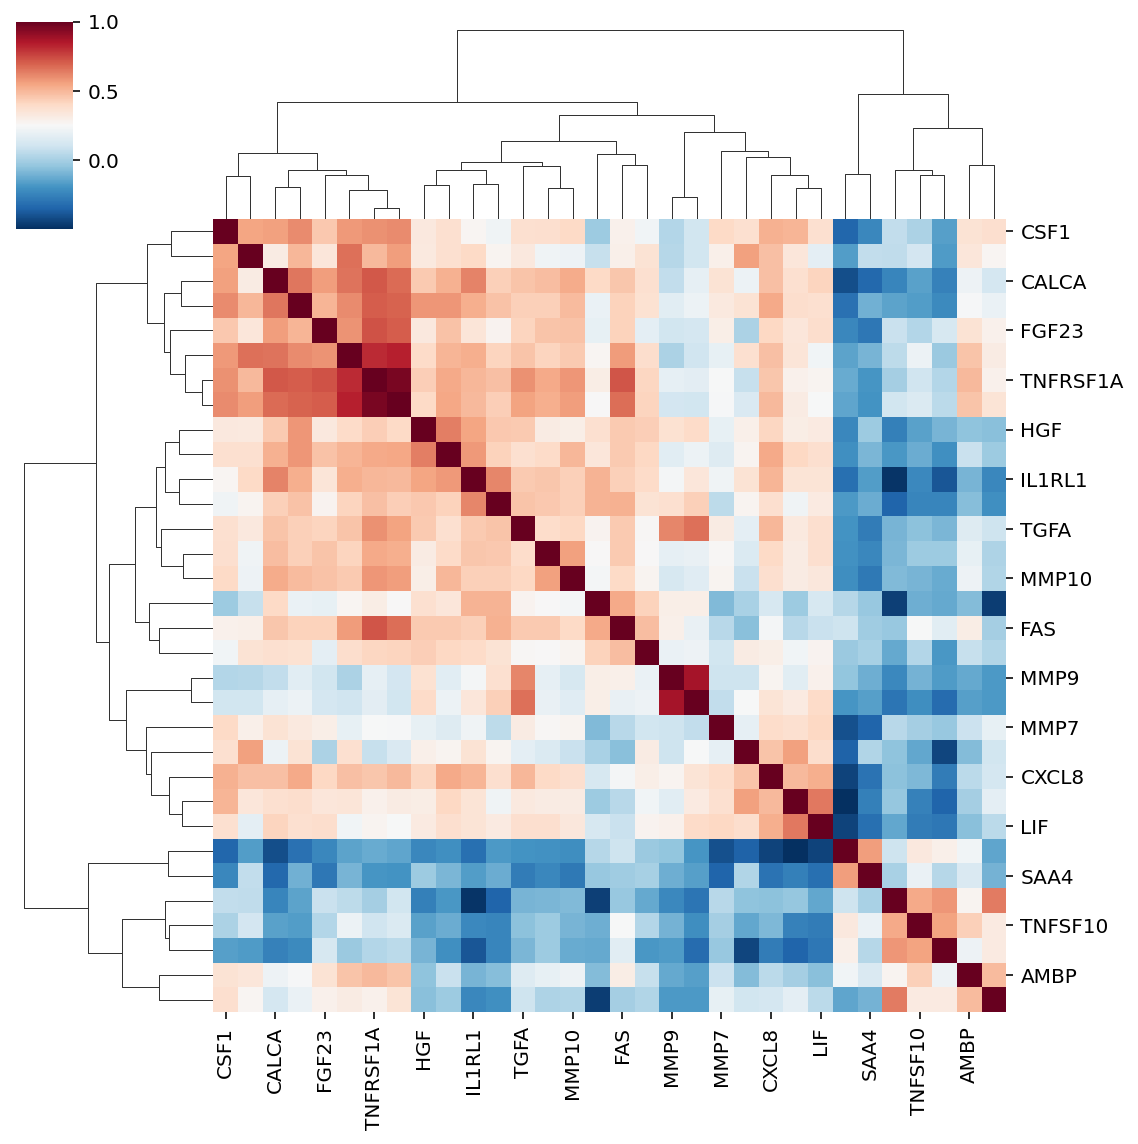

In [8]:
g = sns.clustermap(df.loc[:, pathway_proteins].corr(), 
                   method='complete',
                   cmap='RdBu_r', figsize=(8,8))

### 5- Model for Signature Selection

Load MGH data and construct training feature list with shared feature set.

In [9]:
# we load the MGH clinical data
df_mgh_clin = pd.read_csv(filepath_or_buffer='../data/mgh_data/MGH_COVID_Clinical_Info.txt', sep=';')

# then the proteomic data
df_mgh_olink = pd.read_csv(filepath_or_buffer='../data/mgh_data/MGH_COVID_OLINK_NPX.txt', sep=';')

# we then limit the data to the admission timepoint (day=3)
df_mgh_olink_d3 = df_mgh_olink.loc[df_mgh_olink.Timepoint == 'D3', :]

# then we limit their dataset to proteins we BOTH measured
overlap_protein = df_mgh_olink_d3.UniProt.isin(df_uniprot.columns)
df_mgh_olink_d3 = df_mgh_olink_d3.loc[overlap_protein, :]

# drop duplicate Uniprot codes to enable pivoting with unique index
df_mgh_olink_d3 = df_mgh_olink_d3.drop_duplicates(subset=['subject_id', 'UniProt'])

# pivot to wide format similar to our DataFrame
df_mgh_olink_d3 = df_mgh_olink_d3.pivot(index=['subject_id'], columns='UniProt', values='NPX')

# then merge the clinic and protein data
df_mgh_d3 = df_mgh_clin.merge(df_mgh_olink_d3, how='inner', on='subject_id')

# and limit the MGH data to COVID-19 patients (excluding their controls)
df_mgh_d3 = df_mgh_d3.loc[df_mgh_d3.COVID == 1, :]

# # we then use our metadata from above to rename the columns from uniprot to gene name
df_mgh = df_mgh_d3.rename(uniprot_gene_map, axis=1).rename({'IL8' : 'CXCL8'}, axis=1)

# generate combined DataFrame
shared_proteins = df.columns.values[df.columns.isin(df_mgh.columns)]
messi_shared = df.loc[:, shared_proteins].assign(HUP=1)
mgh_shared = df_mgh.loc[:, shared_proteins].assign(HUP=0).dropna() # since this wasn't pre-processed like our Penn data
combined = pd.concat([messi_shared, mgh_shared], axis=0)

# extract protein values and hospital labels if needed for later
X_shared = combined.loc[:, shared_proteins]
y_hospital = combined.loc[:, 'HUP']

# Standardize for use in UMAP
X_shared = StandardScaler().fit_transform(X_shared)

# generate binary severity label
mod_sev_0_mgh = df_mgh.loc[:, 'WHO 0'] <= 3
mod_sev_7_mgh = df_mgh.loc[:, 'WHO 3'] <= 3
mod_sev_14_mgh = df_mgh.loc[:, 'WHO 7'] <= 3
mod_sev_28_mgh = df_mgh.loc[:, 'WHO 28'] <= 3
df_mgh_d3_gn = df_mgh.assign(mod_sev_d0=mod_sev_0_mgh, mod_sev_d7=mod_sev_7_mgh, 
                             mod_sev_d14=mod_sev_14_mgh, mod_sev_d28=mod_sev_28_mgh)

# make sure pathway protein list includes proteins only in replication data
pathway_proteins = [i for i in pathway_proteins if i in shared_proteins]

Construct training data matrix.

In [10]:
train_X = df.loc[:, pathway_proteins]
train_y = df.loc[~pd.isna(train_X).any(axis=1), 'mod_sev_d28']
train_X = train_X.dropna()

Model fitting routine.

In [11]:
# because we'll be running this notebook repeatedly, we will write this code
# so that the models can be cached on the hard disk and training will only 
# occur if the model doesn't exist

if (path.exists('../mdl/enlr')):
    enlr = pickle.load(open('../mdl/enlr', 'rb'))
    print('Previoulsy trained Elastic Net Logistic Regression Classifier loaded.')
    
else:     
    # implement pipeline for centering/scaling, and then training w/ 10-fold CV
    # varying the penalty and the L1 to L2 ratio
    #
    # notably, we choose our parameters so to get a fair amount of L1-regularization
    # so that the modeling yields a more parsimonious signature
    enlr = Pipeline([('center_scale', StandardScaler()),
                     ('logit', LogisticRegressionCV(penalty='elasticnet',
                                                    cv=10, refit=True,
                                                    solver='saga', max_iter=5000,
                                                    random_state=42, n_jobs=4,
                                                    Cs=10**4,
                                                    l1_ratios=[0.5, 0.6, 0.7, 0.8, 0.9]))])

    # fit model
    enlr.fit(train_X, train_y)
    
    # save model for later re-use without retraining
    pickle.dump(enlr, open('./{0}'.format('../mdl/enlr'), 'wb'))
    print('Elastic Net Logistic Regression Classifier fit and saved.')

# output selected parameters
C = enlr.named_steps['logit'].C_
L1R = enlr.named_steps['logit'].l1_ratio_
print(f'\nC:{C}, L1 Ratio: {L1R}')

# show coefficients
features = train_X.columns
values = enlr['logit'].coef_
df_features = [[i, j] for i, j in zip(features, values.flatten())]
df_features = pd.DataFrame(df_features)
df_features.columns = ['feature', 'value']
df_features.loc[np.abs(df_features.value) > 0, :].sort_values('value', ascending=False)

# store
pdss = list(df_features.loc[np.abs(df_features.value) > 0, :].sort_values('value', ascending=False).feature.values)

Previoulsy trained Elastic Net Logistic Regression Classifier loaded.

C:[0.12551912], L1 Ratio: [0.5]


Plot features, using logistic regression to derive p-values.

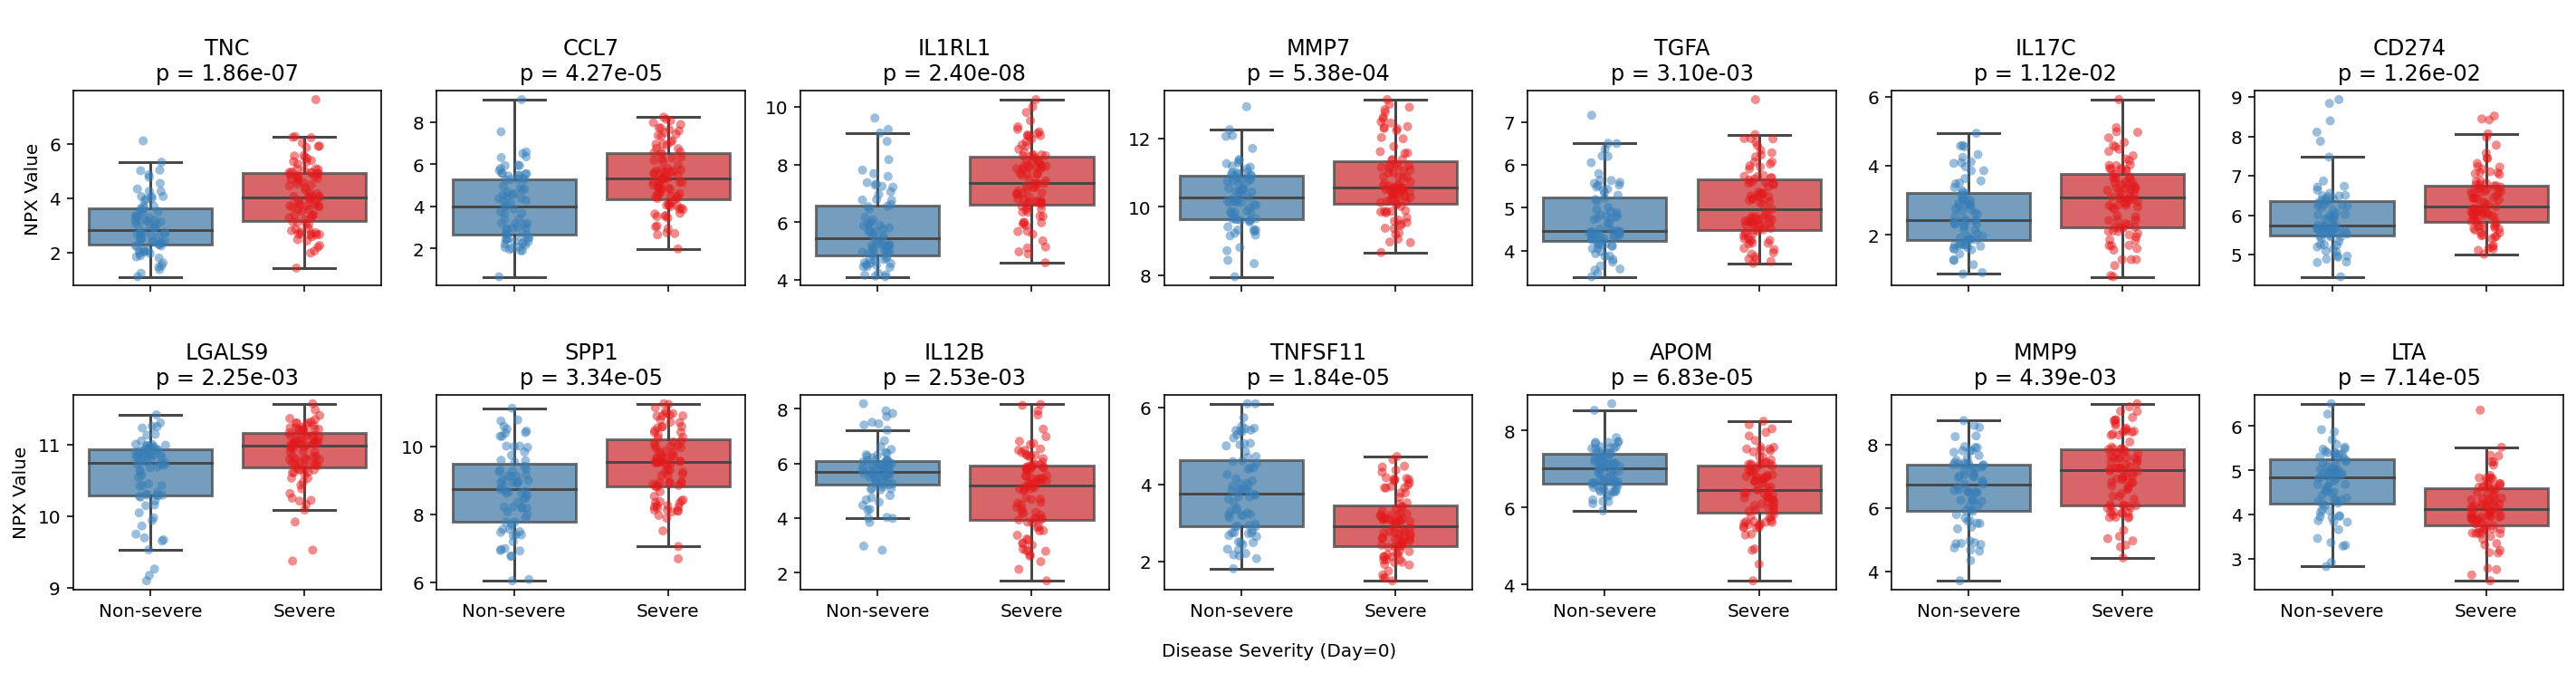

In [12]:
# use logistic regression to calculate p-value
pvalue_results = {}
for i in pdss:
    f = f'mod_sev_d0.astype(int) ~ {i} + age + male_sex + race_BAA + covid19_sx_start + mhcmdz'
    glm = smf.logit(formula=str(f), data=df).fit(disp=0)
    pvalue_results[i] = glm.pvalues[1]

# establish plot and then output results
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20,5), sharex=True, sharey=False)
red = '#e41a1c'
blue = '#377eb8'
cvc_pal = [blue, red]

remap = {True : 'Severe', False : 'Non-severe'}

for i, j in enumerate(pdss):
    if (j in df.columns):
        axes[i // 7][i % 7].set_title('\n' + j + '\np = ' + '{:.2e}'.format(round(pvalue_results[j], 9)))
        g1 = sns.boxplot(x=df.mod_sev_d0.map(remap), y=df.loc[:, j], ax=axes[i // 7][i % 7], 
                         palette=cvc_pal, boxprops=dict(alpha=.75), showfliers = False,
                         order=['Non-severe', 'Severe'])
        g1.set(ylabel=None, xlabel=None)
        
        g2 = sns.stripplot(x=df.mod_sev_d0.map(remap), y=df.loc[:, j], ax=axes[i // 7][i % 7], 
                           palette=cvc_pal, alpha=0.5, order=['Non-severe', 'Severe'])
        g2.set(ylabel=None, xlabel=None)
        
axes[0][0].set(ylabel='NPX Value')
axes[1][0].set(ylabel='NPX Value')
fig.text(0.5, -0.025, 'Disease Severity (Day=0)', ha='center')
fig.tight_layout()

plt.show()

Calculate ability of signature to discriminate.

First, ROC function.

In [13]:
def plot_roc(models, names, colors, title, X, y, n_bootstraps=1000, ci_level=0.95, figsize=(10,10), save_fig=None):
    # establish figure
    plt.figure(figsize=figsize)


    # generate bootstraps
    rng = np.random.RandomState(seed=42)

    bootstrap_indices = []
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y), len(y))
        bootstrap_indices.append(indices)
    save = []
    # evaluate each model on boot straps, adding results to plot
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        bootstrapped_auc = []
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)
        
        for bootstrap_index in bootstrap_indices:
            # obtain ROC curve for BS_i and then add to plot
            roc = roc_curve(y[bootstrap_index], f_hat[bootstrap_index, 1], 
                            drop_intermediate=False)
            
            interp_tpr = np.interp(mean_fpr, roc[0], roc[1])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
#             sns.lineplot(x=roc[0], y=roc[1], ci=None, alpha=0.01, color=colors[i], zorder=1)
        
            # store score for this curve to generate CI
            auc = roc_auc_score(y[bootstrap_index], f_hat[bootstrap_index, 1])
            bootstrapped_auc.append(auc)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=.1)
        
        # determine AUC and CI for this model from bootstrapped runs
        auc = roc_auc_score(y, f_hat[:, 1])
        sorted_scores = np.array(bootstrapped_auc)
        sorted_scores.sort()
        li = (1. - ci_level)/2
        ui = 1 - li
        ci = (sorted_scores[int(li * len(sorted_scores))], sorted_scores[int(ui * len(sorted_scores))])

        # plot curve of principle estimate
        roc_estimate = roc_curve(y, f_hat[:, 1])
        sns.lineplot(x=roc_estimate[0], y=roc_estimate[1], ci=None, color=colors[i], zorder=2,
             label='{0}\n(AUC = {1:.2f} [{2:.2f}, {3:.2f}])'.format(names[i], auc, *ci))

    # add diagonal, labels, title
    plt.plot([0, 1], [0, 1], 'k:')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')

    if save_fig != None:
        plt.savefig(save_fig, dpi=300)

    plt.show()

Construct test matrices.

In [14]:
# generate binary severity label
mod_sev_28_mgh = df_mgh.loc[:, 'WHO 28'] <= 3
df_mgh_d3_gn = df_mgh.assign(mod_sev_d28=mod_sev_28_mgh)

# generate test data
test_X = df_mgh_d3_gn.loc[:, pathway_proteins]
test_y = df_mgh_d3_gn.loc[:, 'mod_sev_d28']

ROC analysis.

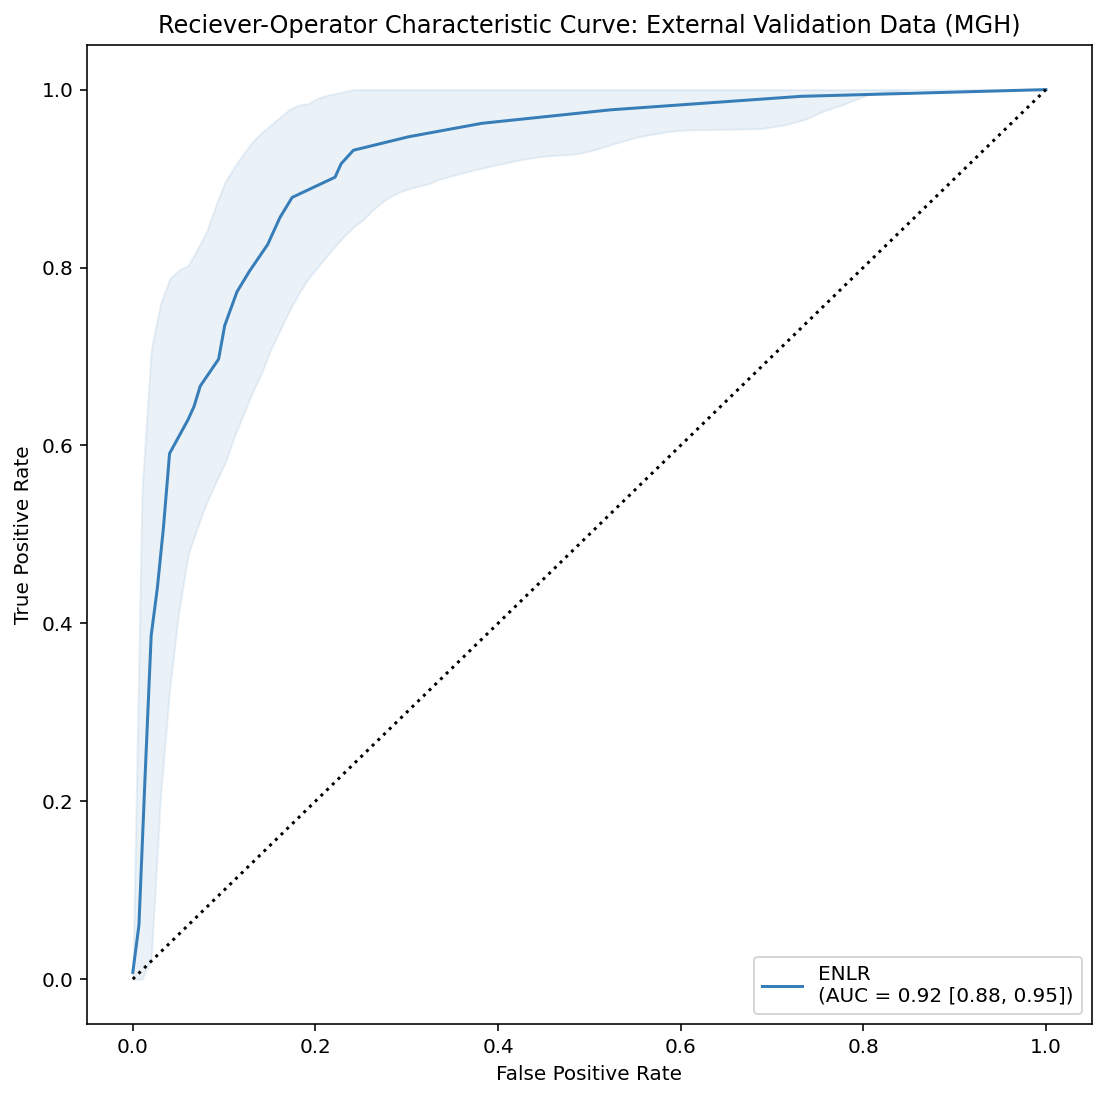

In [15]:
plot_roc(models=[enlr],
            names=['ENLR'],
            colors=['#377eb8'],
            title='Reciever-Operator Characteristic Curve: External Validation Data (MGH)',
            X=test_X, y=test_y.values, ci_level=0.95, figsize=(9,9),
            n_bootstraps=1000, save_fig=None)

Finally, we calculate P(Y=1|X) and save the feature set for HTE analysis in R.

In [16]:
# limit DataFrame to complete protein feature set
df_complete = df.dropna(subset=pathway_proteins).copy()

# calculate P
# P(Y=1|X) for each patient for later use
risk_pdss = enlr.predict_proba(train_X)[:, 1]
df_complete = df_complete.assign(risk_pdss=risk_pdss)

# calculate the predicted class for use in this analysis
risk_group = enlr.predict(train_X)
df_complete = df_complete.assign(risk_group=risk_group)

df_complete.to_csv('../data/COVID-PDSS_final-HTE.csv')